In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble  import AdaBoostClassifier
import seaborn as sns
import glob
from sklearn.neural_network import MLPClassifier
#import graphviz

<h2>Gather</h2>

In [2]:
#Ler o Csv e mostrar as primeiras 5 linhas
df = pd.read_csv("PartidasV9.csv", delimiter = ";")
df.head(5)

,Time,Rank,Rank_,Data,DiasDoTecnicoNoTime,EmCasa,PJ*,V*,E*,D*,TxVit5Jogos,TxDer5Jogos,TxEmp5Jogos,TxVit5Jogos_,TxDer5Jogos_,TxEmp5Jogos_,Resultado
0,Chapecoense,12,10.0,22/07/2019,106,True,11.0,3.0,4.0,4.0,20,0,80,0,80,20,V
1,Palmeiras,12,1.0,13/07/2019,97,True,321.0,108.0,105.0,108.0,0,20,80,80,0,20,E
2,Atlético MG,12,7.0,13/06/2019,67,False,97.0,34.0,31.0,32.0,0,40,60,60,20,20,E
3,Avaí,12,21.0,09/06/2019,63,False,17.0,9.0,5.0,3.0,0,60,40,0,40,60,E
4,Cruzeiro,12,2.0,02/06/2019,56,True,85.0,42.0,22.0,21.0,0,60,40,0,60,40,E


In [3]:
df = df[['Time', 'Rank', 'Rank_','DiasDoTecnicoNoTime','EmCasa','TxVit5Jogos','TxDer5Jogos',
       'TxEmp5Jogos','TxVit5Jogos_','TxDer5Jogos_','TxEmp5Jogos_', 'Resultado'
        , 'V*','D*','E*','PJ*']]
df.head(5)

,Time,Rank,Rank_,DiasDoTecnicoNoTime,EmCasa,TxVit5Jogos,TxDer5Jogos,TxEmp5Jogos,TxVit5Jogos_,TxDer5Jogos_,TxEmp5Jogos_,Resultado,V*,D*,E*,PJ*
0,Chapecoense,12,10.0,106,True,20,0,80,0,80,20,V,3.0,4.0,4.0,11.0
1,Palmeiras,12,1.0,97,True,0,20,80,80,0,20,E,108.0,108.0,105.0,321.0
2,Atlético MG,12,7.0,67,False,0,40,60,60,20,20,E,34.0,32.0,31.0,97.0
3,Avaí,12,21.0,63,False,0,60,40,0,40,60,E,9.0,3.0,5.0,17.0
4,Cruzeiro,12,2.0,56,True,0,60,40,0,60,40,E,42.0,21.0,22.0,85.0


<h2>Clean</h2>

In [4]:
#Limpar qualquer linha com colunas nulas
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 0 to 595
Data columns (total 16 columns):
Time                   497 non-null object
Rank                   497 non-null int64
Rank_                  497 non-null float64
DiasDoTecnicoNoTime    497 non-null int64
EmCasa                 497 non-null bool
TxVit5Jogos            497 non-null int64
TxDer5Jogos            497 non-null int64
TxEmp5Jogos            497 non-null int64
TxVit5Jogos_           497 non-null int64
TxDer5Jogos_           497 non-null int64
TxEmp5Jogos_           497 non-null int64
Resultado              497 non-null object
V*                     497 non-null float64
D*                     497 non-null float64
E*                     497 non-null float64
PJ*                    497 non-null float64
dtypes: bool(1), float64(5), int64(8), object(2)
memory usage: 62.6+ KB


In [5]:
#Converter tabelas em INT
df["Rank_"] = df["Rank_"].astype('int64')
df["Rank"] = df["Rank"].astype('int64')

<h3>Adicionando Caracteristicas</h3>

In [6]:
#Coloca a média de vitórias/Derrotas/Empates sobre o time pelo total de jogos
df['MediaV*'] = (df['V*']/df['PJ*']) * 100
df['MediaD*'] = (df['D*']/df['PJ*']) * 100
df['MediaE*'] = (df['E*']/df['PJ*']) * 100

#Cria uma coluna apresentando a diferença de Rankings
df['DiferencaRank'] = (df['Rank'] - df['Rank_']) * -1

df.sample(5)

,Time,Rank,Rank_,DiasDoTecnicoNoTime,EmCasa,TxVit5Jogos,TxDer5Jogos,TxEmp5Jogos,TxVit5Jogos_,TxDer5Jogos_,TxEmp5Jogos_,Resultado,V*,D*,E*,PJ*,MediaV*,MediaD*,MediaE*,DiferencaRank
189,América,8,22,162,True,40,60,0,40,60,0,V,43.0,13.0,13.0,69.0,62.318841,18.840580,18.840580,14
357,CSA,7,79,181,False,80,0,20,40,40,20,V,4.0,0.0,3.0,7.0,57.142857,0.000000,42.857143,72
387,Cruzeiro,7,8,27,False,40,40,20,60,20,20,V,42.0,21.0,22.0,85.0,49.411765,24.705882,25.882353,1
84,Red Bull,12,138,0,True,60,20,20,60,20,20,V,2.0,1.0,3.0,6.0,33.333333,16.666667,50.000000,126
506,Bragantino,4,36,178,True,80,0,20,80,20,0,V,25.0,9.0,11.0,45.0,55.555556,20.000000,24.444444,32


<h2>Análise Exploratória</h2>

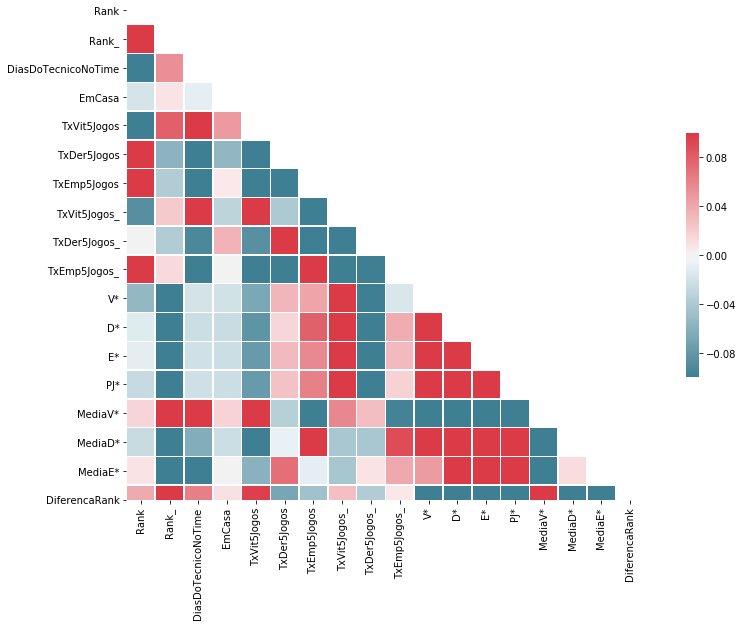

In [7]:
def PlotCorrelationMatrix(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.1, center=0, vmin=-0.1,
        square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
PlotCorrelationMatrix(df)

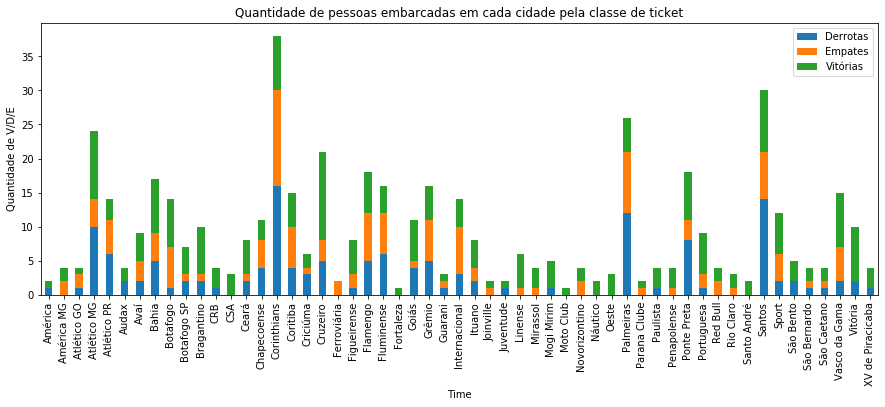

In [8]:
def plot_bar(dataframe, title, stacked, legend, xLabel, yLabel):
    fig, ax = plt.subplots(figsize=(15,5))
    dataframe.plot(kind = 'bar', title = title, stacked = stacked, ax = ax)
    ax.legend(legend)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    
df_ = df.groupby(['Time', 'Resultado'])['PJ*'].count().unstack('Resultado')
plot_bar(df_,'Quantidade de pessoas embarcadas em cada cidade pela classe de ticket', True, 
        ["Derrotas", "Empates", "Vitórias"], 'Time', 'Quantidade de V/D/E')

In [9]:
dummy = pd.get_dummies(df['Time'])
df = df.merge(dummy, left_index=True, right_index=True)
df.head()

,Time,Rank,Rank_,DiasDoTecnicoNoTime,EmCasa,TxVit5Jogos,TxDer5Jogos,TxEmp5Jogos,TxVit5Jogos_,TxDer5Jogos_,...,Rio Claro,Santo André,Santos,Sport,São Bento,São Bernardo,São Caetano,Vasco da Gama,Vitória,XV de Piracicaba
0,Chapecoense,12,10,106,True,20,0,80,0,80,...,0,0,0,0,0,0,0,0,0,0
1,Palmeiras,12,1,97,True,0,20,80,80,0,...,0,0,0,0,0,0,0,0,0,0
2,Atlético MG,12,7,67,False,0,40,60,60,20,...,0,0,0,0,0,0,0,0,0,0
3,Avaí,12,21,63,False,0,60,40,0,40,...,0,0,0,0,0,0,0,0,0,0
4,Cruzeiro,12,2,56,True,0,60,40,0,60,...,0,0,0,0,0,0,0,0,0,0


<h2>Machine Learning</h2>

In [10]:
df1 = df
df2 = df
df1 = df1.drop(columns=['Time', 'Resultado'],axis=1)
def test_classifier(clf, df,params):
    X = df[params].values
    y = df['Resultado']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    clf = clf.fit(X_train, y_train)
    print('Accuracy: ', accuracy_score(clf.predict(X_test), y_test))
    print('Precision: ', precision_score(clf.predict(X_test), y_test, average="macro"))
    print('Recall: ', recall_score(clf.predict(X_test), y_test, average="macro"))
    print('F1: ', f1_score(clf.predict(X_test), y_test, average="macro"))
    print(confusion_matrix(y_test, clf.predict(X_test)))

<h3>Random Forest</h3>

In [11]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=4,
                             random_state=0)

test_classifier(clf,df2,df1.columns)

print (len(clf.feature_importances_))
print (len(df1.columns))
importances = pd.DataFrame({'feature':df1.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
 
importances.head(20)

Accuracy:  0.6606060606060606
Precision:  0.6079774348763896
Recall:  0.6771754932502597
F1:  0.6131076131076131
[[18  9 22]
 [ 3 22 16]
 [ 4  2 69]]
73
73


,importance
feature,
TxDer5Jogos,0.124
TxVit5Jogos,0.104
TxEmp5Jogos,0.099
TxEmp5Jogos_,0.075
EmCasa,0.048
MediaV*,0.046
MediaD*,0.042
TxVit5Jogos_,0.040
D*,0.040


<h3>Naive Bayes</h3>

In [12]:
clf = GaussianNB(priors=None, var_smoothing=1e-09)
test_classifier(clf,df2,df1.columns)

Accuracy:  0.2909090909090909
Precision:  0.3396626292793539
Recall:  0.44939726176839584
F1:  0.26559536354056906
[[27 21  1]
 [24 17  0]
 [46 25  4]]


In [13]:
dummy_clf = DummyClassifier(strategy="most_frequent")
test_classifier(dummy_clf,df2,df1.columns)

Accuracy:  0.45454545454545453
Precision:  0.3333333333333333
Recall:  0.15151515151515152
F1:  0.20833333333333334
[[ 0  0 49]
 [ 0  0 41]
 [ 0  0 75]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [15]:
kernels = ['linear', 'rbf', 'poly']
gammas = [0.1] #, 1, 10, 100
cs = [0.1] #,1,10,100,1000
degrees = [0] #1, 2, 3, 4, 5, 6
for kernel in kernels:
    for gamma in gammas:
        for c in cs:
            for degree in degrees:
                print('Test SVM: Kernel=' + kernel + ' gamma='+ str(gamma)+' C='+str(c)+' Degrees='+str(degree))
                clf = SVC(kernel=kernel, gamma=gamma,C=c,degree=degree)
                test_classifier(clf,df2,df1.columns)

Test SVM: Kernel=linear gamma=0.1 C=0.1 Degrees=0
Accuracy:  0.6727272727272727
Precision:  0.6554880814114264
Recall:  0.6754475703324809
F1:  0.6570292664912524
[[25  8 16]
 [ 2 28 11]
 [ 7 10 58]]
Test SVM: Kernel=rbf gamma=0.1 C=0.1 Degrees=0
Accuracy:  0.45454545454545453
Precision:  0.3333333333333333
Recall:  0.15151515151515152
F1:  0.20833333333333334
[[ 0  0 49]
 [ 0  0 41]
 [ 0  0 75]]
Test SVM: Kernel=poly gamma=0.1 C=0.1 Degrees=0
Accuracy:  0.45454545454545453
Precision:  0.3333333333333333
Recall:  0.15151515151515152
F1:  0.20833333333333334
[[ 0  0 49]
 [ 0  0 41]
 [ 0  0 75]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
